### Basic Run Instructions
This notebook was created in Google Colab and ran using Colab Pro. 
Important Notes:


*   The code is modularized and will run fully if using Google Colab. Otherwise please install the necessary libraries.
*   "apply" functions are computationally intensive and the "swifter" library was installed to expidite these functions. Running these functions will take ~ 7-8 minutes
*   Finetuning of **EACH** BERT model will take approximately 30 minutes





### Step 1: Perform basic EDA of the data
--------------------------------

* The dataset was retrieved by scraping data from mtsamples.com. This dataset contains short descriptions of the medical transcription, the medical specialty classification of the transcriptions, the title of the medical transcription, sample medical transcriptions, and relevant keywords from the medical transcription. It consists of almost 4000 rows that each contain unique medical transcriptions. 

* We will conduct two tasks on this dataset, medical speciality classification and medical document type classification.


## a) Required Libraries and Utility Functions

In [ ]:
#basic libraries
import numpy as np
import pandas as pd
import re
import string

#plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Plot medical specialty counts from dataframe
def plot_medical_speciality_counts(df, title):
  plt.figure(figsize=(15,6))
  plt.xticks(rotation=90)

  counts = df['medical_specialty'].value_counts().sort_values(ascending=False)

  sns.countplot(x='medical_specialty', data = df , color='steelblue' ,order=counts.index)

  plt.xlabel("Medical Speciality")
  plt.ylabel("Count of Documents")
  plt.title(title)

  plt.show()

In [ ]:
# Lists for cleaning dataset text
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [ ]:
# Clean text by removing special characters
def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ',text)

    text = extra_symbol_remover.sub('',text)
    # This function seems to decrease model accuracy
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

# For some reason, lemmatization also seems to decrease model accuracy
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))    
    return ' '.join(wordlist) 

In [ ]:
# Tokenize on a sentence level, then clean each sentence
def tokenize_and_clean(text):
  sentences = sent_tokenize(text)
  sentences = map(clean_text, sentences)
  return '. '.join(sentences)

## a) Download and load the dataset

In [ ]:
file_path = "mtsamples.csv"

In [ ]:
!wget https://raw.githubusercontent.com/lipet2k/biobert_v1.1_pubmed/main/mtsamples.csv -O mtsamples.csv

--2023-04-18 00:13:46--  https://raw.githubusercontent.com/lipet2k/biobert_v1.1_pubmed/main/mtsamples.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17007236 (16M) [text/plain]
Saving to: ‘mtsamples.csv’

mtsamples.csv       100%[===================>]  16.22M  --.-KB/s    in 0.1s    

2023-04-18 00:13:46 (127 MB/s) - ‘mtsamples.csv’ saved [17007236/17007236]



In [ ]:
df_complete = pd.read_csv(file_path)

## b) Filter out unecessary columns and rows

In [ ]:
#dropping redundant rows or columns
df_complete.drop('Unnamed: 0', axis=1, inplace=True)
df_complete =df_complete.drop(['description','sample_name','keywords'], axis=1)

df_complete.head(10)

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
5,Bariatrics,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST..."
6,Bariatrics,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b..."
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
8,Bariatrics,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the..."
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."


## c) Perform basic EDA on dataset

In [ ]:
df_complete['transcription'] = df_complete['transcription'].astype(str)
all_words = (" ".join(df_complete["transcription"]).split())
num_words = len(all_words)
unique_words = set(all_words)
num_unique_words = len(unique_words)
avg_doc_length = df_complete["transcription"].str.split().apply(len).mean()


print("Total no of words " + str(num_words))
print("Total no of unique words " + str(num_unique_words))
print("Average no of words per each document " + str(avg_doc_length))


Total no of words 2311452
Total no of unique words 70899
Average no of words per each document 462.38287657531504


In [ ]:
num_docs = len(df_complete)

num_categories  = len(df_complete['medical_specialty'].unique())

docs_per_category = df_complete["medical_specialty"].value_counts()

print("Total no of category " + str(num_categories))
print("no of documents per each category " + str(docs_per_category))

Total no of category 40
no of documents per each category  Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosme

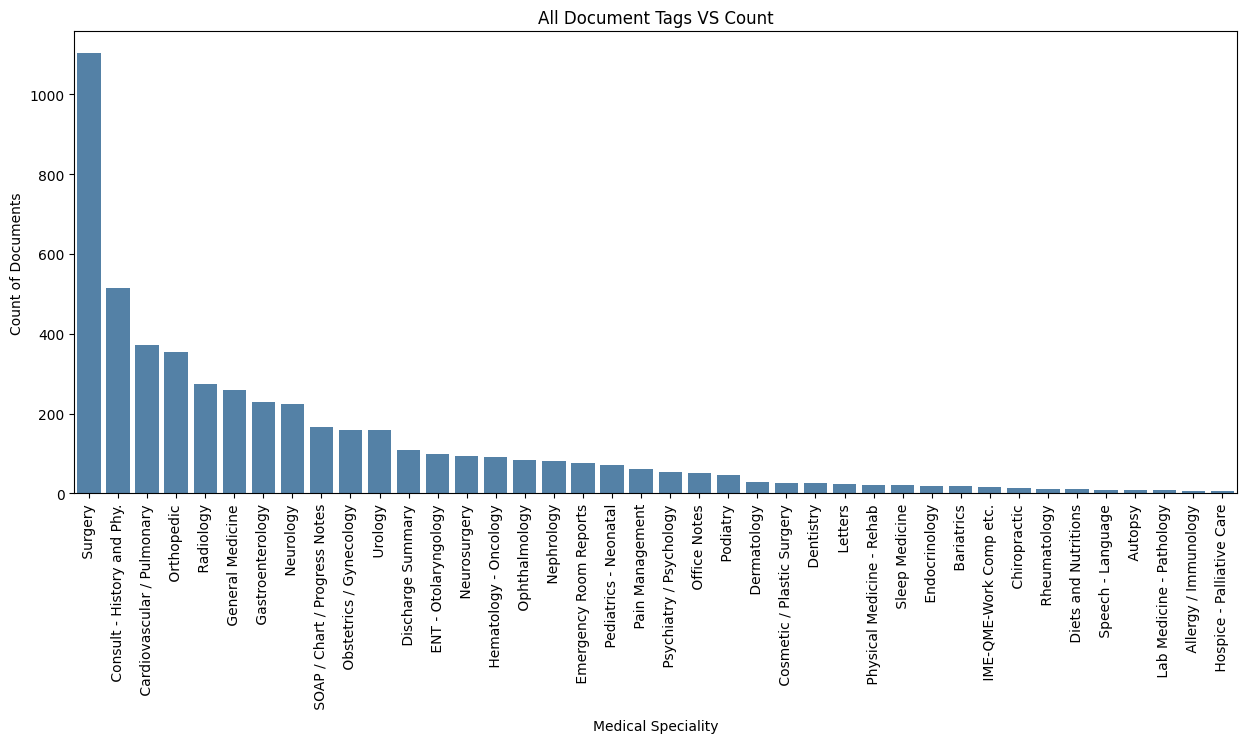

In [ ]:
plot_medical_speciality_counts(df_complete, "All Document Tags VS Count")

In [ ]:
counts = df_complete['medical_specialty'].value_counts()

df_complete = df_complete[~df_complete['medical_specialty'].isin(counts[counts < 50 ].index)]

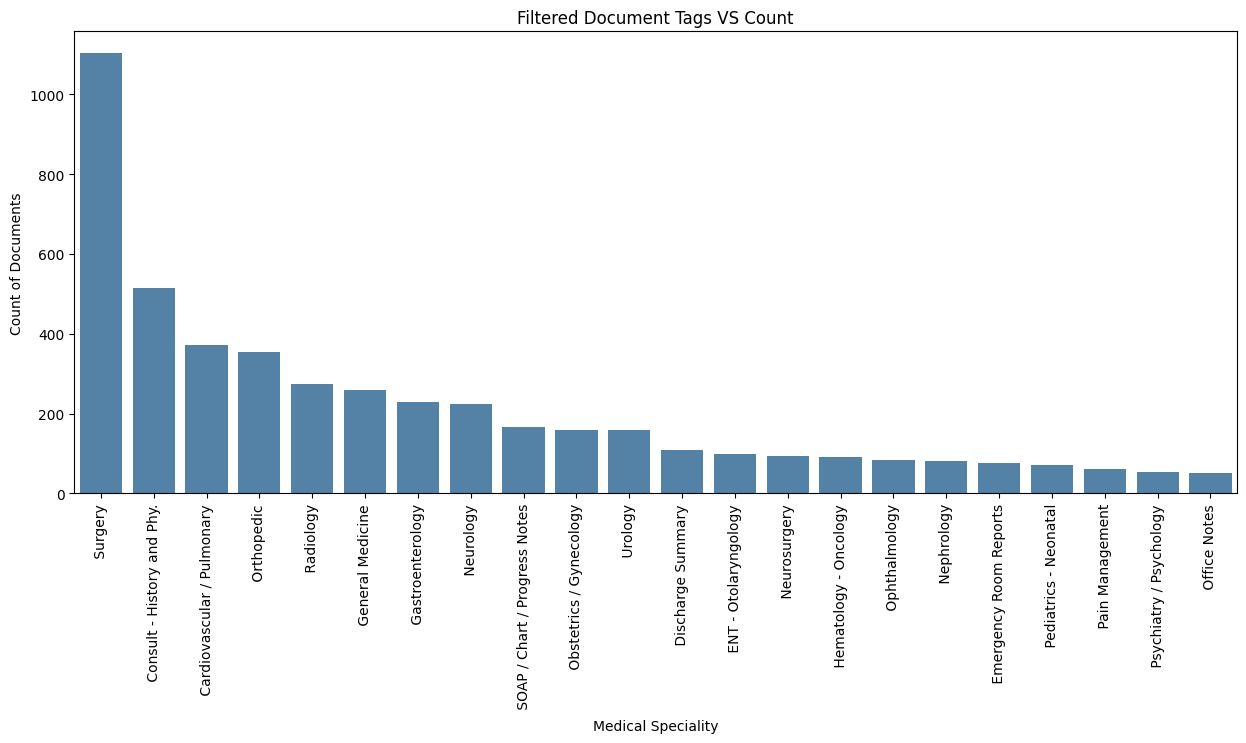

In [ ]:
plot_medical_speciality_counts(df_complete, "Filtered Document Tags VS Count")

## d) perform cleaning and lemmatization on the transcript column

In [ ]:
# df_complete['transcription'] = df_complete['transcription'].apply(clean_text)
df_complete['transcription'] = df_complete['transcription'].apply(tokenize_and_clean)

In [ ]:
df_complete['transcription'].tolist()[:5]

['2d mmode    1. left atrial enlargement with left atrial diameter of 47 cm 2. normal size right and left ventricle 3. normal lv systolic function with left ventricular ejection fraction of 51 4. normal lv diastolic function 5. no pericardial effusion 6. normal morphology of aortic valve  mitral valve  tricuspid valve  and pulmonary valve 7. pa systolic pressure is 36 mmhg doppler    1. mild mitral and tricuspid regurgitation 2. trace aortic and pulmonary regurgitation',
 '1. the left ventricular cavity size and wall thickness appear normal. the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70 to 75. there is nearcavity obliteration seen. there also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function. there is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by doppler examinatio

Step 2: Perform medical entity extractions - anatomies , problems , diseases , text 
--------------------------------
To extract important entity information from medical transcription data, we utilized medical entity recognizer models. We used two models to extract anatomy entities and clinical entities - En_ner_bionlp13cg_md and En_ner_bc5cdr_md, respectively.

## a) Import medical entity extraction libraries

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
!pip install en_ner_bionlp13cg_md


!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz

!pip install spacy
!pip install scispacy
!pip install stanza
!pip install swifter

import stanza
import spacy
import en_ner_bionlp13cg_md
import swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz (125.1 MB)
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz (125.1 MB)
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached spacy-3.4.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached thinc-8.1.9-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.

/usr/local/lib/python3.9/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_ner_bionlp13cg_md' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## a) anatomy entity extraction - practise

In [ ]:
nlp_ner = en_ner_bionlp13cg_md.load()
def anatomy_entities( text):
    wordlist=[]
    doc = nlp_ner(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)  


/usr/local/lib/python3.9/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_ner_bionlp13cg_md' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
df_complete['anatomy_entities'] = df_complete['transcription'].swifter.apply(anatomy_entities)

Pandas Apply:   0%|          | 0/4680 [00:00<?, ?it/s]

## b) clinical entity extractions - organ name

In [ ]:
nlp_clinical = spacy.load('en_ner_bc5cdr_md')

def clinical_entities(text):
  doc = nlp_clinical(text)
  entity_text = ""
  for entity in doc.ents:
    entity_text += " " + entity.text
  return entity_text

/usr/local/lib/python3.9/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
df_complete['clinical_entities'] = df_complete['transcription'].swifter.apply(clinical_entities)

Pandas Apply:   0%|          | 0/4680 [00:00<?, ?it/s]

In [ ]:
df_complete['clinical_anatomy_entities'] = df_complete['clinical_entities'].str.cat(df_complete['anatomy_entities'], sep=' ')


Step 3: Apply basic Mulitnomial bayes to assert class overlap/hierarchy
--------------------------------

To enhance the performance of the logistic regression model utilizing the TF-IDF vectorizer for medical specialty classification, we employed a multi-step approach. 


Firstly, we preprocessed the transcription data through the use of medical named entity recognition libraries, allowing us to extract relevant entities. We then trained three distinct models for medical specialty classification, one focusing solely on anatomy entities, another utilizing clinical entities, and a third using a combination of both.

## b) Import mutliNB libraries and other utliity functions 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# Plot confusion matrix for labels vs labels
def plot_confusion_matrix(confusion_matrix, category_list , plot_title ):
  fig = plt.figure(figsize=(10,10))
  ax= fig.add_subplot(1,1,1)
  sns.heatmap(confusion_matrix, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  ax.set_title("Confusion Matrix - " + plot_title); 
  ax.xaxis.set_ticklabels(category_list); ax.yaxis.set_ticklabels(category_list);
  plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
  plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
  plt.show()

## b) use basic mutlinomial naive bayes to evaluate classifcation

In [ ]:
df_complete['medical_specialty'] = df_complete['medical_specialty'].str.replace('\s+', '')


X_train, X_test, y_train, y_test = train_test_split(df_complete['transcription'], df_complete['medical_specialty'], test_size=0.3, random_state=21)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)


y_pred = nb.predict(X_test_vec)
category_list = df_complete.medical_specialty.unique()

## c) evaluate the results and take the conclusions

Confusion Matrix:
['Urology' 'Gastroenterology' 'Ophthalmology' ... 'Surgery' 'Radiology'
 'Gastroenterology']
F1 Score: 0.28465340412247575
Accuracy: 0.3126780626780627


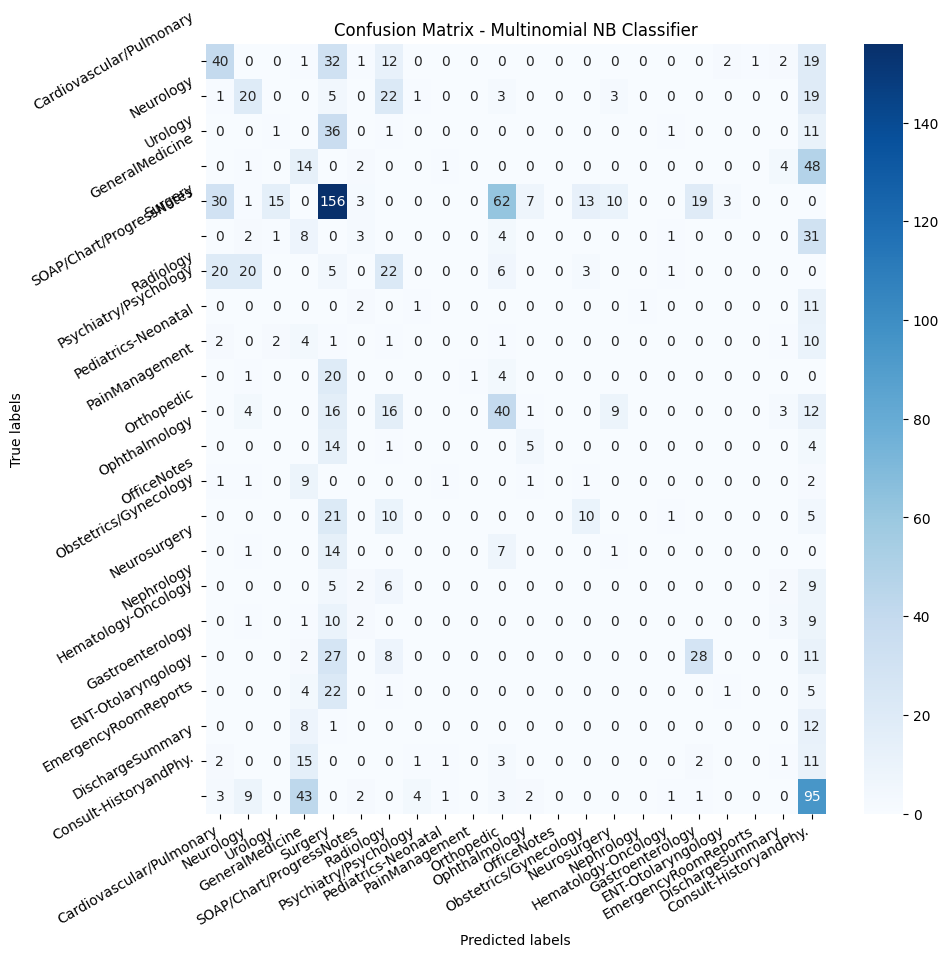

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred , labels =category_list )
print("Confusion Matrix:")
print(y_pred)

f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1score)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


plot_confusion_matrix(conf_matrix, category_list, "Multinomial NB Classifier" )

In [ ]:
print(classification_report(y_test,y_pred,labels=category_list))

                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.40      0.36      0.38       110
               Neurology       0.33      0.27      0.30        74
                 Urology       0.05      0.02      0.03        50
         GeneralMedicine       0.13      0.20      0.16        70
                 Surgery       0.41      0.49      0.44       319
SOAP/Chart/ProgressNotes       0.18      0.06      0.09        50
               Radiology       0.22      0.29      0.25        77
   Psychiatry/Psychology       0.14      0.07      0.09        15
     Pediatrics-Neonatal       0.00      0.00      0.00        22
          PainManagement       1.00      0.04      0.07        26
              Orthopedic       0.30      0.40      0.34       101
           Ophthalmology       0.31      0.21      0.25        24
             OfficeNotes       0.00      0.00      0.00        16
   Obstetrics/Gynecology       0.37      0.21      0.27        47
         

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusions: 

Above case we can see that surgery clearly overlaps other medical categories and is being classified as such.

Step 4 : Define the tasks and split the datasets into train validation and test partitions 
--------------------------------
* To address the issues of overlapping categories in medical document classification, the dataset has been redefined into two separate classifications - one based on medical specialty and the other based on document type. 

* Task 1- Medical Speciality Classification: The medical specialty task includes categories such as 'Cardiovascular/Pulmonary', 'Neurology', 'Orthopedic', and 'Gastroenterology', among others. To improve the accuracy of classification, related specialties have been merged, such as 'Nephrology' and 'Urology', and 'Neurosurgery' and 'Neurology'. In doing so, parent medical specialty classes such as 'Surgery' and 'General Medical' - which could apply to multiple classes - could be excluded for the time being, providing greater clarity and accuracy in classification.

* Task 2-Medical Document Type Classification:Similarly, the medical document type task includes categories such as 'SOAP/Chart/ProgressNotes', 'OfficeNotes', 'EmergencyRoomReports', and 'DischargeSummary'. There is a significant skew in the distribution of these categories, which can be addressed during model training. By separating the dataset into these two classifications, greater clarity and accuracy can be achieved in medical document classification.

## a) filtering medical speciality classes

In [ ]:
medical_speciality_filter = ['Cardiovascular/Pulmonary' ,'Neurology' ,'Urology' ,
  'Orthopedic' , 'Obstetrics/Gynecology' ,'Neurosurgery' ,'Nephrology',
 'Gastroenterology' , 'Radiology'] # values to filter
df_medical_speciality = df_complete[df_complete['medical_specialty'].isin(medical_speciality_filter)]


In [ ]:
df_medical_speciality.loc[:,'medical_specialty'] = df_medical_speciality.loc[:,'medical_specialty'].replace('Nephrology', 'Urology')
df_medical_speciality.loc[:,'medical_specialty'] = df_medical_speciality.loc[:,'medical_specialty'].replace('Neurosurgery', 'Neurology')

<ipython-input-28-9f3cd7f310d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_speciality.loc[:,'medical_specialty'] = df_medical_speciality.loc[:,'medical_specialty'].replace('Nephrology', 'Urology')
<ipython-input-28-9f3cd7f310d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_speciality.loc[:,'medical_specialty'] = df_medical_speciality.loc[:,'medical_specialty'].replace('Neurosurgery', 'Neurology')


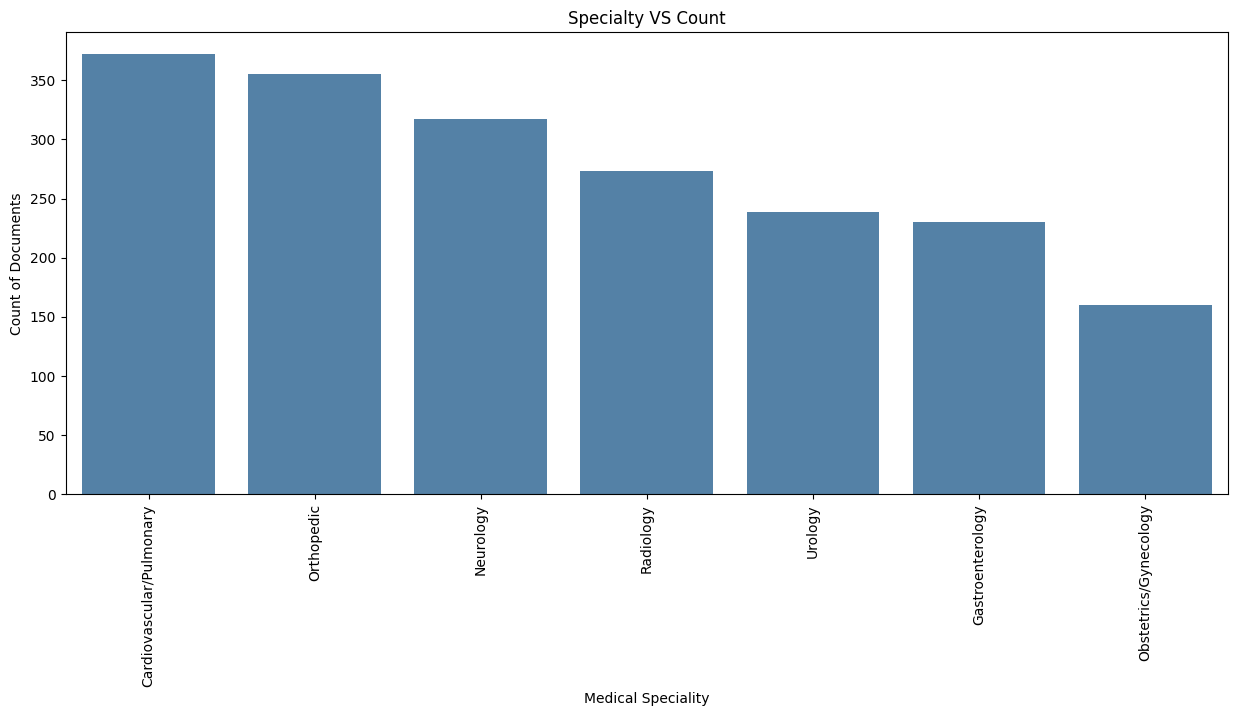

In [ ]:
plot_medical_speciality_counts(df_medical_speciality, 'Specialty VS Count')

## b) filtering medical document type classes

In [ ]:
medical_document_type_filter = [
'SOAP/Chart/ProgressNotes' ,
 'OfficeNotes' ,
 'EmergencyRoomReports' , 'DischargeSummary'  ]# values to filter
df_document_type = df_complete[df_complete['medical_specialty'].isin(medical_document_type_filter)]

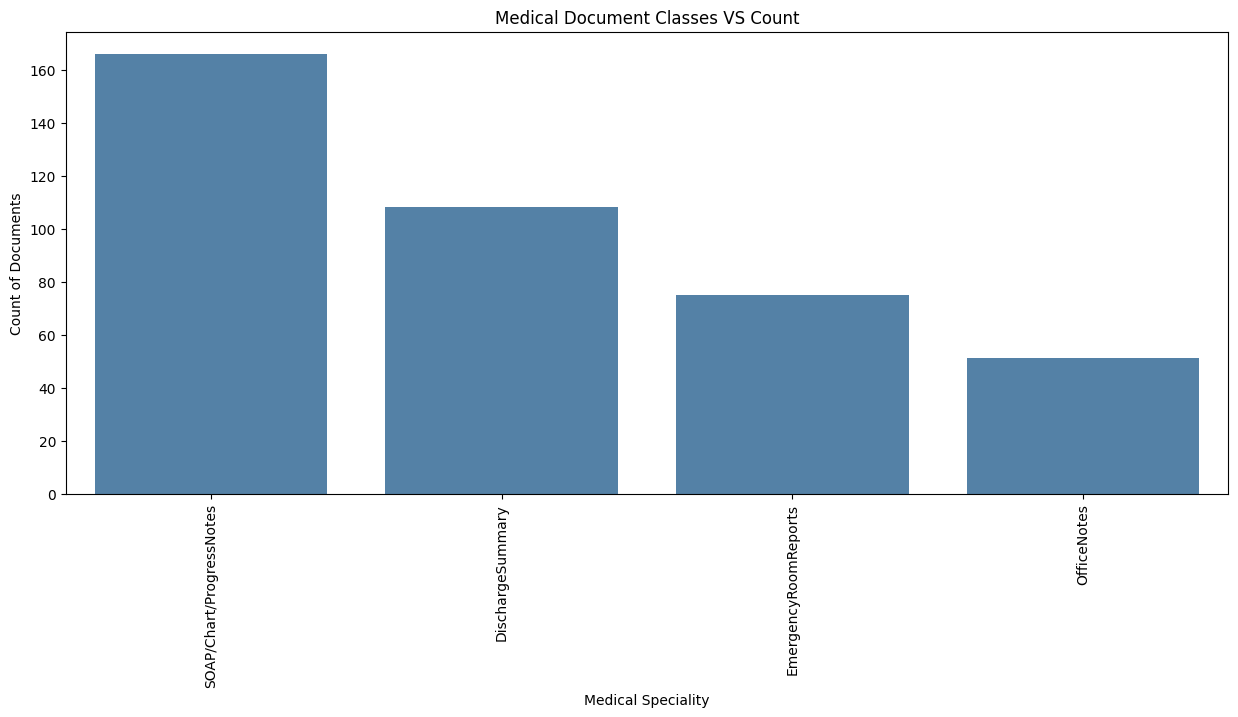

In [ ]:
plot_medical_speciality_counts(df_document_type, "Medical Document Classes VS Count")

###c)  break the data into standard train test and validation for both the tasks

In [ ]:
df_medical_speciality['text'] = df_medical_speciality['transcription']
df_medical_speciality['label'] , uniques_ms = pd.factorize(df_medical_speciality['medical_specialty'])

<ipython-input-32-03bc964d6b42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_speciality['text'] = df_medical_speciality['transcription']
<ipython-input-32-03bc964d6b42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medical_speciality['label'] , uniques_ms = pd.factorize(df_medical_speciality['medical_specialty'])


In [ ]:
train_df_ms_all, test_df_ms = train_test_split(df_medical_speciality, test_size=0.2, random_state=42)
train_df_ms, val_df_ms = train_test_split(train_df_ms_all, test_size=0.2, random_state=42)


In [ ]:
df_document_type['text'] = df_document_type['transcription']
df_document_type['label'] , uniques_dt = pd.factorize(df_document_type['medical_specialty'])

<ipython-input-34-e86733f2580b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_document_type['text'] = df_document_type['transcription']
<ipython-input-34-e86733f2580b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_document_type['label'] , uniques_dt = pd.factorize(df_document_type['medical_specialty'])


In [ ]:
train_df_dt_all, test_df_dt = train_test_split(df_document_type, test_size=0.2, random_state=42)
train_df_dt, val_df_dt = train_test_split(train_df_dt_all, test_size=0.2, random_state=42)

Step 5 : Train Logistic Regression Classifier on TDIDF Vectorizer on both Tasks!
--------------------------------

## a) Import necessary libraries and write TFIDF, PCA , logistic regression and tsne functions

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [185]:
def get_tfidf_vectorizer(X_train, X_test , enable_pca):
    vectorizer = TfidfVectorizer(sublinear_tf = True, max_features = 1000, stop_words = 'english', ngram_range = (1,3), min_df = 5, max_df = 0.75)
    X_train_tdidf  = vectorizer.fit_transform(X_train.tolist())
    X_test_tdidf = vectorizer.transform(X_test.tolist())

    if enable_pca:
      pca = PCA(n_components=0.95)
      X_train_tdidf = pca.fit_transform(X_train_tdidf.toarray())
      X_test_tdidf = pca.transform(X_test_tdidf.toarray())
    return X_train_tdidf , X_test_tdidf

def logistic_regression(X_train_tdidf, Y_train):
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_tdidf, Y_train )
    return clf

def plot_tsne(tfIdfMat,labels , perplexity ):
  tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=perplexity).fit_transform(tfIdfMat)

  plt.figure(figsize=(12,8))
  palette = sns.hls_palette(10, l=.4, s=.9)
  plt.title("scatter plot")
  sns.scatterplot(
      x=tsne_results[:,0], y=tsne_results[:,1],
      hue=labels,
      palette= palette,
      legend="full",
      alpha=0.3
  )
  plt.show()

## b) Task1 (medical speciality) -  TFIDF + PCA on **ANATOMY ENTITIES** + LR classifer

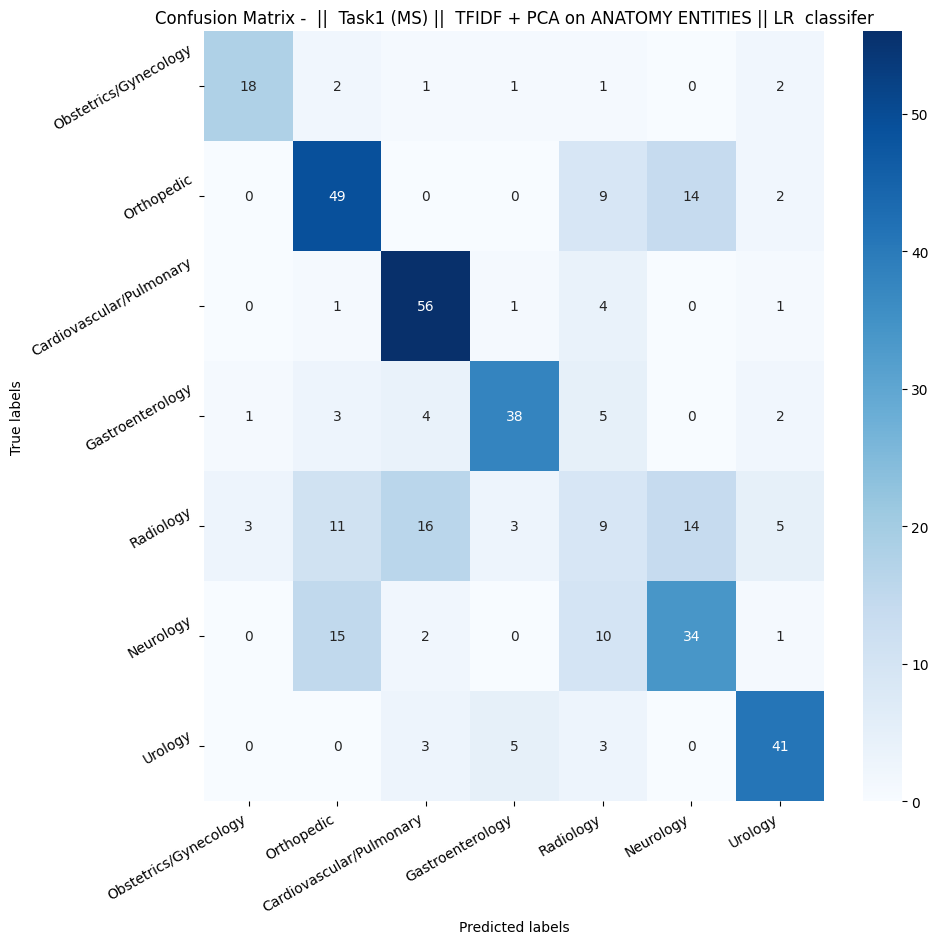

In [182]:
X_train_tdidf_anatomy , X_test_tdidf_anatomy = get_tfidf_vectorizer( train_df_ms_all["anatomy_entities"],test_df_ms["anatomy_entities"] , True )

clf_model_anatomy  = logistic_regression(X_train_tdidf_anatomy, train_df_ms_all["medical_specialty"])

y_pred_anatomy = clf_model_anatomy.predict(X_test_tdidf_anatomy)
y_test = test_df_ms["medical_specialty"]

category_list = train_df_ms_all.medical_specialty.unique()
cm_anatomy = confusion_matrix(y_test, y_pred_anatomy, labels= category_list)
plot_confusion_matrix(cm_anatomy, category_list ,  " ||  Task1 (MS) ||  TFIDF + PCA on ANATOMY ENTITIES || LR  classifer")

In [170]:
print(classification_report(y_test,y_pred_anatomy,labels=category_list))

                          precision    recall  f1-score   support

   Obstetrics/Gynecology       0.82      0.72      0.77        25
              Orthopedic       0.61      0.66      0.64        74
Cardiovascular/Pulmonary       0.69      0.90      0.78        63
        Gastroenterology       0.80      0.75      0.78        53
               Radiology       0.28      0.18      0.22        61
               Neurology       0.55      0.55      0.55        62
                 Urology       0.77      0.79      0.78        52

                accuracy                           0.64       390
               macro avg       0.64      0.65      0.64       390
            weighted avg       0.62      0.64      0.63       390



<ipython-input-168-69c2b6955ebf>:23: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(


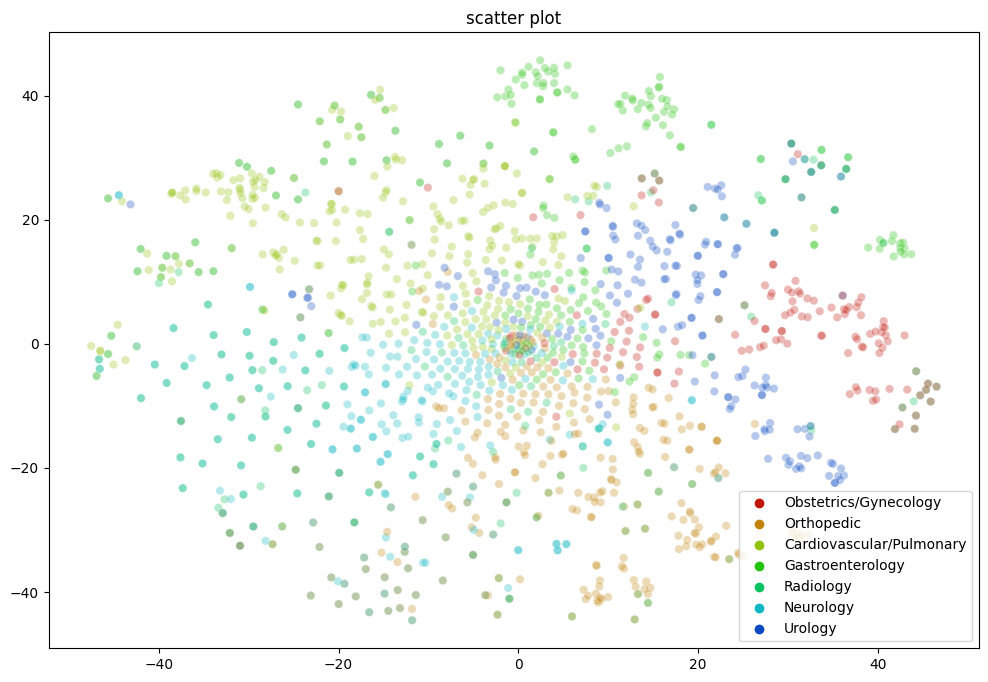

In [171]:
plot_tsne(X_train_tdidf_anatomy , train_df_ms_all["medical_specialty"].tolist(),40)

## c) Task1 (medical speciality) -  TFIDF + PCA on **CLINICAL ENTITIES** + LR classifer

In [172]:
X_train_tdidf_clinical , X_test_tdidf_clinical = get_tfidf_vectorizer( train_df_ms_all["clinical_entities"],test_df_ms["clinical_entities"] , True )

clf_model_clinical  = logistic_regression(X_train_tdidf_clinical, train_df_ms_all["medical_specialty"])

y_pred_clinical = clf_model_clinical.predict(X_test_tdidf_clinical)
y_test = test_df_ms["medical_specialty"]



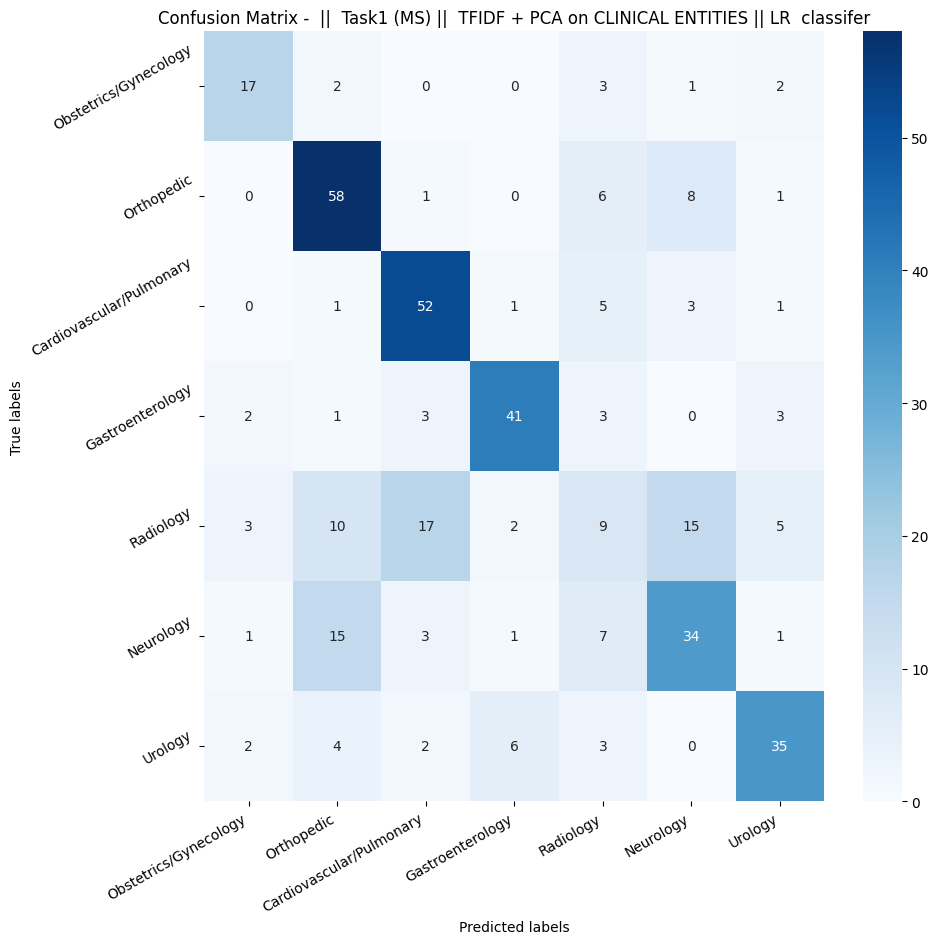

In [173]:
cm_clinical = confusion_matrix(y_test, y_pred_clinical, labels= category_list)
plot_confusion_matrix(cm_clinical, category_list, " ||  Task1 (MS) ||  TFIDF + PCA on CLINICAL ENTITIES || LR  classifer")

In [174]:
print(classification_report(y_test,y_pred_clinical,labels=category_list))

                          precision    recall  f1-score   support

   Obstetrics/Gynecology       0.68      0.68      0.68        25
              Orthopedic       0.64      0.78      0.70        74
Cardiovascular/Pulmonary       0.67      0.83      0.74        63
        Gastroenterology       0.80      0.77      0.79        53
               Radiology       0.25      0.15      0.19        61
               Neurology       0.56      0.55      0.55        62
                 Urology       0.73      0.67      0.70        52

                accuracy                           0.63       390
               macro avg       0.62      0.63      0.62       390
            weighted avg       0.61      0.63      0.61       390



<ipython-input-168-69c2b6955ebf>:23: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(


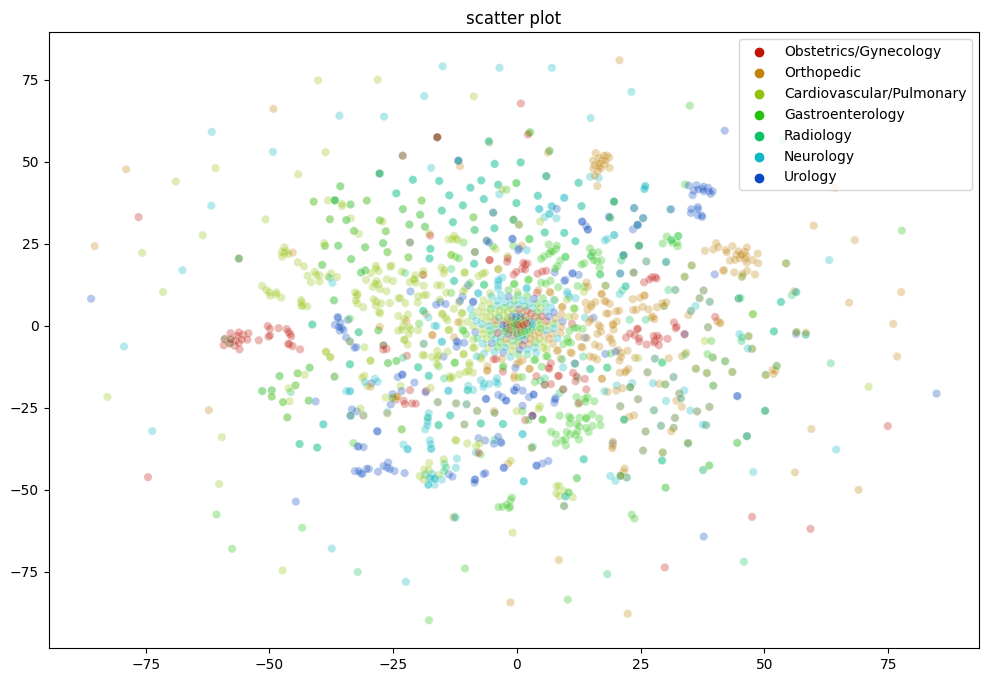

In [175]:
plot_tsne(X_train_tdidf_clinical , train_df_ms_all["medical_specialty"].tolist(),40)

## e) Task1 (medical speciality) -  TFIDF + PCA on **CLINICAL and ANATOMY ENTITIES** + LogisticRegression classifer

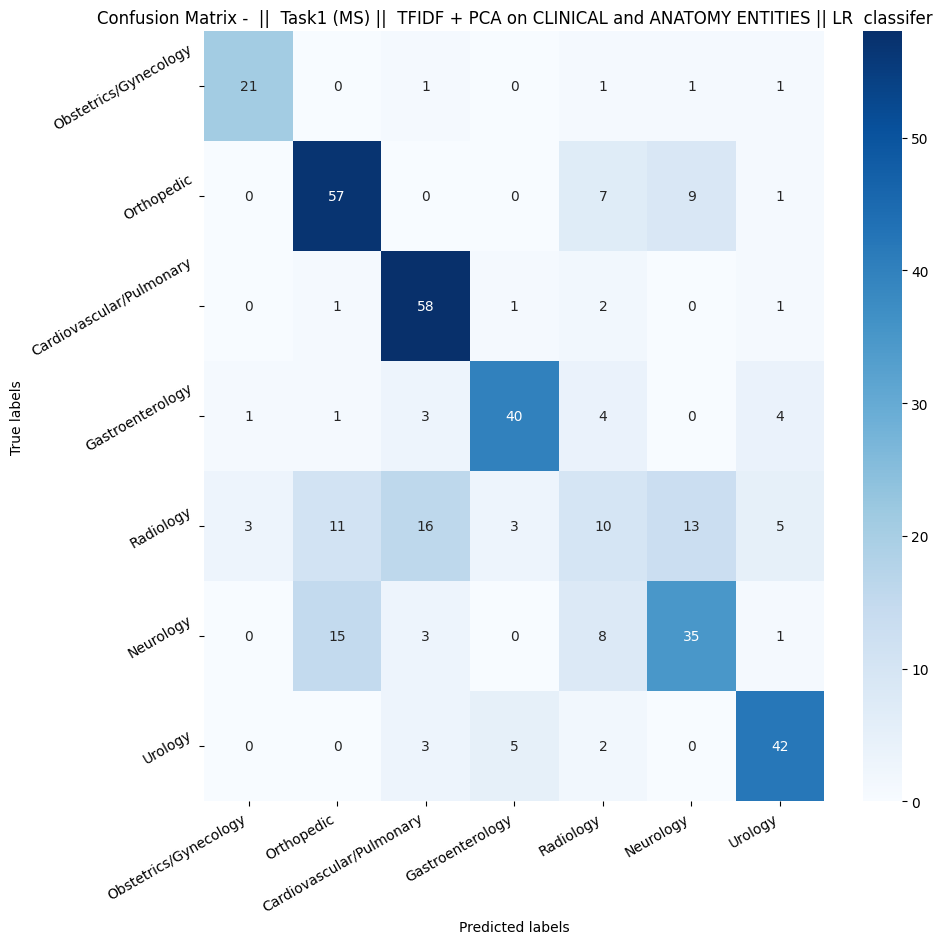

In [183]:
X_train_tdidf_clinical_anatomy , X_test_tdidf_clinical_anatomy = get_tfidf_vectorizer( train_df_ms_all["clinical_anatomy_entities"],test_df_ms["clinical_anatomy_entities"] , True )

clf_model_clinical_anatomy  = logistic_regression(X_train_tdidf_clinical_anatomy, train_df_ms_all["medical_specialty"])

y_pred_clinical_anatomy = clf_model_clinical_anatomy.predict(X_test_tdidf_clinical_anatomy)
y_test = test_df_ms["medical_specialty"]

category_list = train_df_ms_all.medical_specialty.unique()
cm_clinical_anatomy = confusion_matrix(y_test, y_pred_clinical_anatomy, labels= category_list)
plot_confusion_matrix(cm_clinical_anatomy, category_list,  " ||  Task1 (MS) ||  TFIDF + PCA on CLINICAL and ANATOMY ENTITIES || LR  classifer")

In [184]:
print(classification_report(y_test,y_pred_clinical_anatomy ,labels=category_list))

                          precision    recall  f1-score   support

   Obstetrics/Gynecology       0.84      0.84      0.84        25
              Orthopedic       0.67      0.77      0.72        74
Cardiovascular/Pulmonary       0.69      0.92      0.79        63
        Gastroenterology       0.82      0.75      0.78        53
               Radiology       0.29      0.16      0.21        61
               Neurology       0.60      0.56      0.58        62
                 Urology       0.76      0.81      0.79        52

                accuracy                           0.67       390
               macro avg       0.67      0.69      0.67       390
            weighted avg       0.65      0.67      0.65       390



<ipython-input-168-69c2b6955ebf>:23: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(


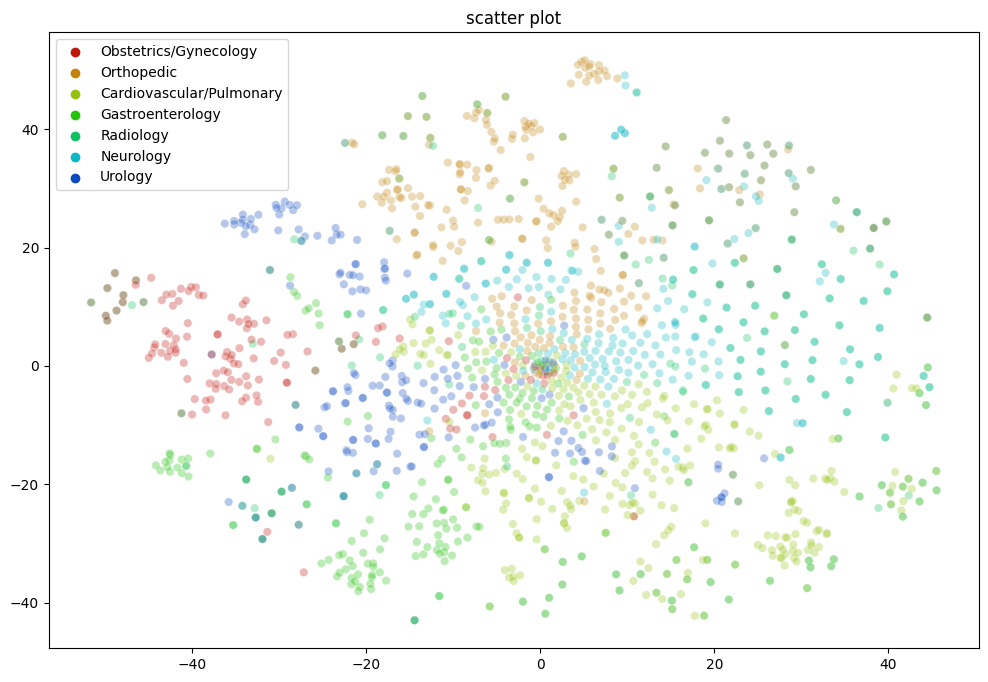

In [178]:
plot_tsne(X_train_tdidf_clinical_anatomy , train_df_ms_all["medical_specialty"].tolist(),40)

## e) Task 2 (medical document type ) -  TFIDF + PCA on **TRANSCRIPTION** + LogisticRegression classifer

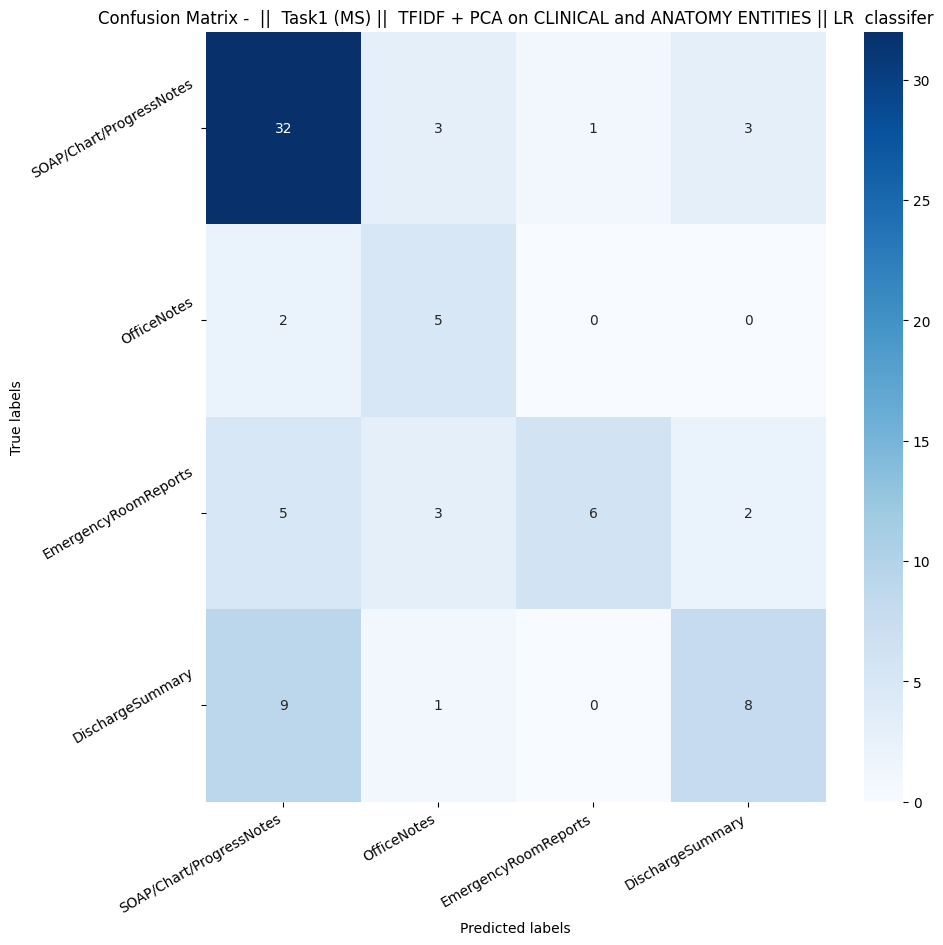

In [186]:
X_train_tdidf_document_type, X_test_tdidf_document_type = get_tfidf_vectorizer( train_df_dt_all["clinical_anatomy_entities"],test_df_dt["clinical_anatomy_entities"] , True )

smote_over_sample = SMOTE(sampling_strategy='minority')
labels = train_df_dt_all["medical_specialty"].tolist()
X_train_tdidf_document_type, labels = smote_over_sample.fit_resample(X_train_tdidf_document_type, labels)

clf_model_document_type  = logistic_regression(X_train_tdidf_document_type,labels)

y_pred_document_type = clf_model_document_type.predict(X_test_tdidf_document_type)
y_test = test_df_dt["medical_specialty"]




category_list = train_df_dt_all.medical_specialty.unique()
cm_document_type= confusion_matrix(y_test, y_pred_document_type, labels= category_list)
plot_confusion_matrix(cm_document_type, category_list,  " ||  Task1 (MS) ||  TFIDF + PCA on CLINICAL and ANATOMY ENTITIES || LR  classifer")

In [187]:
print(classification_report(y_test,y_pred_document_type ,labels=category_list))

                          precision    recall  f1-score   support

SOAP/Chart/ProgressNotes       0.67      0.82      0.74        39
             OfficeNotes       0.42      0.71      0.53         7
    EmergencyRoomReports       0.86      0.38      0.52        16
        DischargeSummary       0.62      0.44      0.52        18

                accuracy                           0.64        80
               macro avg       0.64      0.59      0.57        80
            weighted avg       0.67      0.64      0.63        80



### EVALUATING MEDICAL BERT BASED MODELS AND PLOTTING RESULTS

## a) Import necessary libraries

In [ ]:
# Importing pip transformers gives a 'UTF-8' error, this is to resolve that issue
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers
!pip -q install evaluate
!pip -q install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import evaluate
from transformers import AutoModel, AutoTokenizer
from datasets import load_metric, load_dataset

from tqdm.auto import tqdm

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import pyarrow as pa
import datasets
from datasets import load_dataset, DatasetDict

def convert_df_to_arrow_ds(df):
  table = pa.Table.from_pandas(df)

  # create Arrow Dataset from Arrow Table
  dataset = datasets.dataset_dict.DatasetDict({'my_dataset': datasets.Dataset.from_dict(pa.Table.to_pydict(table))})['my_dataset']
  return dataset

## b) Fine Tune BERT Models

In [ ]:
'''
**Code help from FineTuning_BERT class notebook (Notebook 18)**

This class loads a given Huggingface model checkpoint as the base model, 
and freezes parameters from training if the base model shouldn't be trainable.
It also sets up a classification layer according to the num_labels provided.

** Outputs from the `forward` method are not logits because the softmax function is not applied
'''
class ClassifierModel(nn.Module):
  def __init__(self, model_checkpoint, classifier, base_model_trainable = True):
    super(ClassifierModel, self).__init__()

    # Load the model checkpoint, add a classification layer
            # Instantiate BERT model
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
    self.base_model = AutoModel.from_pretrained(model_checkpoint)
    self.classifier = classifier # import the classifier architecture from init

    # check if base_model_trainable; Freeze parameters if not
    if not base_model_trainable:
      for param in self.base_model.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask, pool, **kwargs):
    embedding_output = self.base_model(input_ids, attention_mask) # output shape: (batch_size, sequence_length, 768)
    last_hidden_state = embedding_output[0]  
    #if pool is true use the average token embedding, otherwise use the [CLS] token embedding
    #if pool:
    #  classifier_input = torch.mean(last_hidden_state, dim=1)
    #else:
    classifier_input = last_hidden_state[:,0,:]

    output = self.classifier(classifier_input)
    return output

In [ ]:
# Load the bert model and create ClassifierModel with architecture
# return the associated tokenizer and model
def loadcheckpoint(checkpoint_path, architecture):
  tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
  frozen_base = ClassifierModel(model_checkpoint=checkpoint_path, classifier=architecture, base_model_trainable=False) 
  frozen_base.to(device)
  return tokenizer, frozen_base

##Initialize BERT Base + FNN Classifier Models

In [ ]:
# Load the pretrained bert model and its tokenizer
uncased_model_checkpoint = "bert-base-uncased"              # See https://huggingface.co/bert-base-uncased 
# These layers were the optimal configuration that we found: the NN is composed
# of input layer (768), Hidden (256), Dropout (p=0.5), ReLU, Output (7)
tokenizer, uncased_base_frozen = loadcheckpoint(uncased_model_checkpoint, nn.Sequential(
            nn.Linear(768, 256),          
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 7),
        ))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Load the pretrained bert model and its tokenizer for document types
# These layers were the optimal configuration that we found: the NN is composed
# of input layer (768), Hidden (256), Dropout (p=0.5), ReLU, Output (7)
tokenizer, uncased_base_frozen_dt = loadcheckpoint(uncased_model_checkpoint, nn.Sequential(
            nn.Linear(768, 256),          
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 7),
        ))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Initialize BioBERT + FNN Classifier Models

In [ ]:
# Load the pretrained biobert model and its tokenizer
biobert_model_checkpoint = "dmis-lab/biobert-v1.1"
# These layers were the optimal configuration that we found: the NN is composed
# of input layer (768), Hidden (256), Dropout (p=0.5), ReLU, Output (7)
tokenizer, biobert_base_frozen = loadcheckpoint(biobert_model_checkpoint, nn.Sequential(
            nn.Linear(768, 256),          
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 7),
        ))

In [ ]:
# Load the pretrained biobert model and its tokenizer for document types
# These layers were the optimal configuration that we found: the NN is composed
# of input layer (768), Hidden (256), Dropout (p=0.5), ReLU, Output (7)
tokenizer, biobert_base_frozen_dt = loadcheckpoint(biobert_model_checkpoint, nn.Sequential(
            nn.Linear(768, 256),          
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 7),
        ))

##Initialize ClinicalBERT + FNN Classifier Model

In [ ]:
# Load the pretrained clinicalbert model and its tokenizer
clinical_model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
# These layers were the optimal configuration that we found: the NN is composed
# of input layer (768), Hidden (256), Dropout (p=0.5), ReLU, Output (7)              
tokenizer, clinical_base_frozen = loadcheckpoint(clinical_model_checkpoint, nn.Sequential(
            nn.Linear(768, 256),          
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 7),
        ))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Create train, validation, and test datasets for medical specialty models
dataset_dict_ms = DatasetDict({
    'train': convert_df_to_arrow_ds(train_df_ms.drop(['medical_specialty', 'transcription', 'anatomy_entities', 'clinical_entities', 'clinical_anatomy_entities'], axis=1)),
    'val': convert_df_to_arrow_ds(val_df_ms.drop(['medical_specialty', 'transcription', 'anatomy_entities', 'clinical_entities', 'clinical_anatomy_entities'], axis=1)),
        'test': convert_df_to_arrow_ds(test_df_ms.drop(['medical_specialty', 'transcription', 'anatomy_entities', 'clinical_entities', 'clinical_anatomy_entities'], axis=1))
})

In [ ]:
# Create train, validation, and test datasets for document type models
dataset_dict_dt = DatasetDict({
    'train': convert_df_to_arrow_ds(train_df_dt.drop(['medical_specialty', 'transcription', 'anatomy_entities', 'clinical_entities', 'clinical_anatomy_entities'], axis=1)),
    'val': convert_df_to_arrow_ds(val_df_dt.drop(['medical_specialty', 'transcription', 'anatomy_entities', 'clinical_entities', 'clinical_anatomy_entities'], axis=1)),
        'test': convert_df_to_arrow_ds(test_df_dt.drop(['medical_specialty', 'transcription', 'anatomy_entities', 'clinical_entities', 'clinical_anatomy_entities'], axis=1))
})

## c) Data Formatting and Loading

In [ ]:
# The best batch size we found was 8, we also experimented with 16 and 32
# for various configurations. They did not seem to increase performance.
BATCH_SIZE = 8

'''
** Code inspired by Notebook 18, Finetuning BERT**
Load and tokenize data from dictionaries
'''
def load_dataloader(dataset_dict, tokenizer):
  dataset = dataset_dict

  # Preprocess and Tokenize data
  def preprocess_function(examples):
      return tokenizer(examples["text"], max_length=512,  truncation=True, padding='max_length')

  tokenized_datasets = dataset.map(preprocess_function, batched=True)

  # We dont need these columns
  tokenized_datasets = tokenized_datasets.remove_columns(["text", "token_type_ids"])
  # # Set the format of the dataset to return PyTorch tensors instead of lists:
  tokenized_datasets.set_format("torch")

  # Reduce data to speed up computation
  train_dataset = tokenized_datasets["train"].shuffle(seed=42)
  eval_dataset = tokenized_datasets["val"].shuffle(seed=42)

  # Data loader (useful for batching data)
  train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return train_dataloader, eval_dataloader

In [ ]:
# Create dataloaders for finetuning
train_dataloader_ms, eval_dataloader_ms = load_dataloader(dataset_dict_ms, tokenizer)
train_dataloader_dt, eval_dataloader_dt = load_dataloader(dataset_dict_dt, tokenizer)

Map:   0%|          | 0/1244 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

## d) Finetune and Prediction Functions

In [ ]:
'''
Code help from FineTuning_BERT class notebook

Finetunes the BERT models and prints training loss and validation accuracy
'''
def finetune( model, 
             pool,
             num_epochs, 
             learning_rate,
             train_dataloader, 
             eval_dataloader,
             metric = evaluate.load("accuracy"), 
             device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):

  progress_bar_train = tqdm(range(num_epochs * len(train_dataloader)))
  progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

  running_loss = 0.0
  total_step = len(train_dataloader)

  # Loss and Optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=learning_rate)

  ## Train and evaluate model for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    ### TRAINING ####
    model.train()
    for i, batch in enumerate(train_dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}

      # Forward pass
      outputs = model(**batch, pool = pool)
      # encoded = one_hot_encode(batch['label'], 7).to('cuda')
      loss = loss_fn(outputs, batch['label'])
      

      # Backward and optimize
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()  # zero the parameter gradients
      progress_bar_train.update(1)
      # print losses
      running_loss += loss.item()
      if (i+1) % 100 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}' 
                  .format(epoch+1, num_epochs, i+1, total_step, running_loss / 100))
          running_loss = 0.0

    #### EVALUATION ####
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch, pool = pool)

        predictions = torch.argmax(outputs, dim=-1)
        metric.add_batch(predictions=predictions, references=batch['label'])
        progress_bar_eval.update(1)
        
    print ('Epoch [{}/{}], Validation Accuracy: {:.4f}' 
                  .format(epoch+1, num_epochs, metric.compute()['accuracy']))

In [ ]:
# Save the fine tuned model
def save_fine_tune(model, model_name, num_epochs):
  PATH = 'bert-v1.1' + '_' + model_name + '_' + str(num_epochs) + '_EPOCH'
  torch.save(model.state_dict(), PATH)

In [ ]:
# Define a function to predict the sentiment of a single text string
# returns the predicted label associated with the text string
def predict(model, pool, tokenizer, text, uniques):
    input_dict = tokenizer(text, max_length=512,  truncation=True, padding='max_length', return_tensors="pt").to(device)
    outputs = model(**input_dict, pool=pool)
    text_code = torch.argmax(outputs, dim=-1)
    return uniques[text_code.cpu().numpy()]

In [ ]:
# Generate predictions from model
def get_predictions(model, uniques, dataset_dict):
  y_test = dataset_dict['test']['label']
  y_test = [uniques[label] for label in y_test]
  x_test = dataset_dict['test']['text']
  return y_test, [predict(model, False, tokenizer, text, uniques) for text in x_test]

In [ ]:
# From testing this seems to be the optimal number of epochs.
# We've also tried 5, 10, and 20 epochs, but the validation accuracy
# seems to increase significantly after increasing the number of epochs
NUM_EPOCHS = 30
from sklearn.metrics import classification_report

## e) Fine Tune Models (Base, BioBERT, Clinical) - Plot Confusion Matrix - Print Classification Reports

**Base BERT Model + FNN Classifier Medical Specialty Finetuning**

In [ ]:
finetune(model=uncased_base_frozen, 
             pool=True,
             learning_rate=0.0001,
             num_epochs=NUM_EPOCHS, 
             train_dataloader=train_dataloader_ms, 
             eval_dataloader=eval_dataloader_ms)
save_fine_tune(model=uncased_base_frozen, model_name="uncased_ms_frozen", num_epochs=NUM_EPOCHS)

  0%|          | 0/4680 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Epoch [1/30], Step [100/156], Training Loss: 1.9280
Epoch [1/30], Validation Accuracy: 0.2596
Epoch [2/30], Step [100/156], Training Loss: 1.9133
Epoch [2/30], Validation Accuracy: 0.1955
Epoch [3/30], Step [100/156], Training Loss: 1.9041
Epoch [3/30], Validation Accuracy: 0.2468
Epoch [4/30], Step [100/156], Training Loss: 1.9027
Epoch [4/30], Validation Accuracy: 0.2853
Epoch [5/30], Step [100/156], Training Loss: 1.8854
Epoch [5/30], Validation Accuracy: 0.2692
Epoch [6/30], Step [100/156], Training Loss: 1.8742
Epoch [6/30], Validation Accuracy: 0.2885
Epoch [7/30], Step [100/156], Training Loss: 1.8878
Epoch [7/30], Validation Accuracy: 0.2949
Epoch [8/30], Step [100/156], Training Loss: 1.8575
Epoch [8/30], Validation Accuracy: 0.3237
Epoch [9/30], Step [100/156], Training Loss: 1.8530
Epoch [9/30], Validation Accuracy: 0.3558
Epoch [10/30], Step [100/156], Training Loss: 1.8529
Epoch [10/30], Validation Accuracy: 0.3494
Epoch [11/30], Step [100/156], Training Loss: 1.8383
Epoch

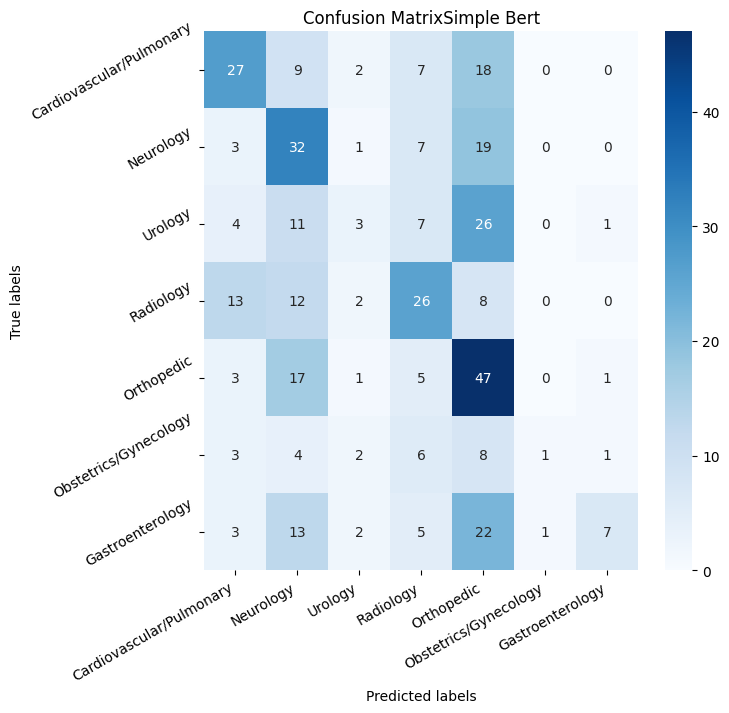

In [ ]:
y_test, y_test_pred = get_predictions(uncased_base_frozen, uniques_ms, dataset_dict_ms)
conf_matrix = confusion_matrix(y_test, y_test_pred , labels =uniques_ms)
plot_confusion_matrix(confusion_matrix=conf_matrix, category_list=uniques_ms, plot_title="Simple Bert")

In [ ]:
print(classification_report(y_test,y_test_pred,labels=uniques_ms))

                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.48      0.43      0.45        63
               Neurology       0.33      0.52      0.40        62
                 Urology       0.23      0.06      0.09        52
               Radiology       0.41      0.43      0.42        61
              Orthopedic       0.32      0.64      0.42        74
   Obstetrics/Gynecology       0.50      0.04      0.07        25
        Gastroenterology       0.70      0.13      0.22        53

                accuracy                           0.37       390
               macro avg       0.42      0.32      0.30       390
            weighted avg       0.41      0.37      0.33       390



**BioBERT + FNN Classifer Medical Specialty Finetuning**

In [ ]:
finetune(model=biobert_base_frozen, 
             pool=True,
             learning_rate=0.0001,
             num_epochs=NUM_EPOCHS, 
             train_dataloader=train_dataloader_ms, 
             eval_dataloader=eval_dataloader_ms)
save_fine_tune(model=biobert_base_frozen, model_name="biobert_ms_frozen", num_epochs=NUM_EPOCHS)

  0%|          | 0/4680 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Epoch [1/30], Step [100/156], Training Loss: 1.8926
Epoch [1/30], Validation Accuracy: 0.2917
Epoch [2/30], Step [100/156], Training Loss: 1.8010
Epoch [2/30], Validation Accuracy: 0.4712
Epoch [3/30], Step [100/156], Training Loss: 1.7170
Epoch [3/30], Validation Accuracy: 0.4904
Epoch [4/30], Step [100/156], Training Loss: 1.6157
Epoch [4/30], Validation Accuracy: 0.5513
Epoch [5/30], Step [100/156], Training Loss: 1.5357
Epoch [5/30], Validation Accuracy: 0.5417
Epoch [6/30], Step [100/156], Training Loss: 1.4580
Epoch [6/30], Validation Accuracy: 0.5737
Epoch [7/30], Step [100/156], Training Loss: 1.3915
Epoch [7/30], Validation Accuracy: 0.6186
Epoch [8/30], Step [100/156], Training Loss: 1.3343
Epoch [8/30], Validation Accuracy: 0.6026
Epoch [9/30], Step [100/156], Training Loss: 1.3169
Epoch [9/30], Validation Accuracy: 0.6442
Epoch [10/30], Step [100/156], Training Loss: 1.2439
Epoch [10/30], Validation Accuracy: 0.6731
Epoch [11/30], Step [100/156], Training Loss: 1.2005
Epoch

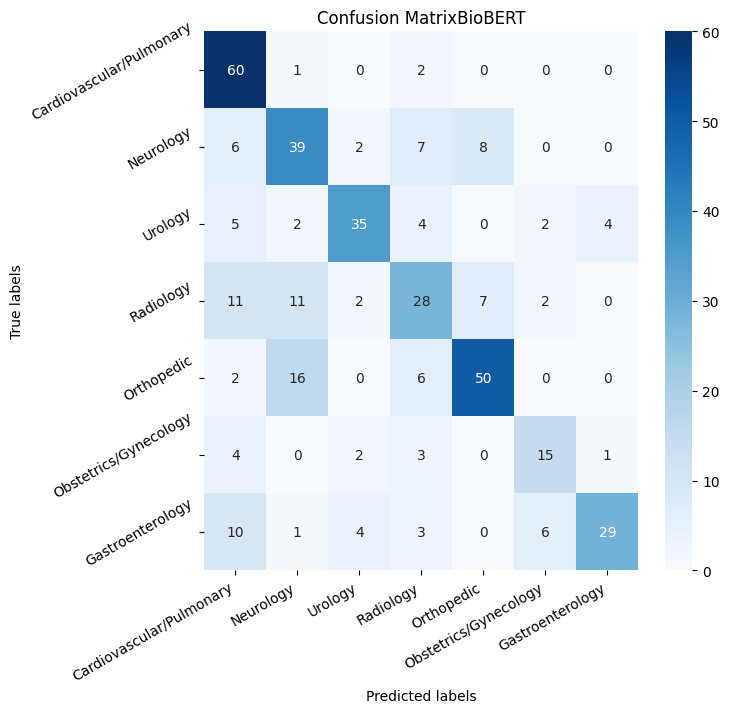

In [ ]:
y_test, y_test_pred = get_predictions(biobert_base_frozen, uniques_ms, dataset_dict_ms)
conf_matrix = confusion_matrix(y_test, y_test_pred , labels =uniques_ms)
plot_confusion_matrix(confusion_matrix=conf_matrix, category_list=uniques_ms, plot_title="BioBERT")

In [ ]:
print(classification_report(y_test,y_test_pred,labels=uniques_ms))

                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.61      0.95      0.75        63
               Neurology       0.56      0.63      0.59        62
                 Urology       0.78      0.67      0.72        52
               Radiology       0.53      0.46      0.49        61
              Orthopedic       0.77      0.68      0.72        74
   Obstetrics/Gynecology       0.60      0.60      0.60        25
        Gastroenterology       0.85      0.55      0.67        53

                accuracy                           0.66       390
               macro avg       0.67      0.65      0.65       390
            weighted avg       0.67      0.66      0.65       390



**ClinicalBERT + FNN Classifier Medical Specialty Fine Tuning**

In [ ]:
finetune(model=clinical_base_frozen, 
             pool=True,
             num_epochs=NUM_EPOCHS, 
             learning_rate=0.0001,
             train_dataloader=train_dataloader_ms, 
             eval_dataloader=eval_dataloader_ms)
save_fine_tune(model=clinical_base_frozen, model_name="clinical_ms_frozen", num_epochs=NUM_EPOCHS)

  0%|          | 0/4680 [00:00<?, ?it/s]

  0%|          | 0/1170 [00:00<?, ?it/s]

Epoch [1/30], Step [100/156], Training Loss: 0.7695
Epoch [1/30], Validation Accuracy: 0.6763
Epoch [2/30], Step [100/156], Training Loss: 0.7866
Epoch [2/30], Validation Accuracy: 0.6538
Epoch [3/30], Step [100/156], Training Loss: 0.8130
Epoch [3/30], Validation Accuracy: 0.6731
Epoch [4/30], Step [100/156], Training Loss: 0.7763
Epoch [4/30], Validation Accuracy: 0.6442
Epoch [5/30], Step [100/156], Training Loss: 0.7627
Epoch [5/30], Validation Accuracy: 0.6378
Epoch [6/30], Step [100/156], Training Loss: 0.7571
Epoch [6/30], Validation Accuracy: 0.6571
Epoch [7/30], Step [100/156], Training Loss: 0.7423
Epoch [7/30], Validation Accuracy: 0.6506
Epoch [8/30], Step [100/156], Training Loss: 0.7439
Epoch [8/30], Validation Accuracy: 0.6635
Epoch [9/30], Step [100/156], Training Loss: 0.7563
Epoch [9/30], Validation Accuracy: 0.6474
Epoch [10/30], Step [100/156], Training Loss: 0.7487
Epoch [10/30], Validation Accuracy: 0.6314
Epoch [11/30], Step [100/156], Training Loss: 0.7169
Epoch

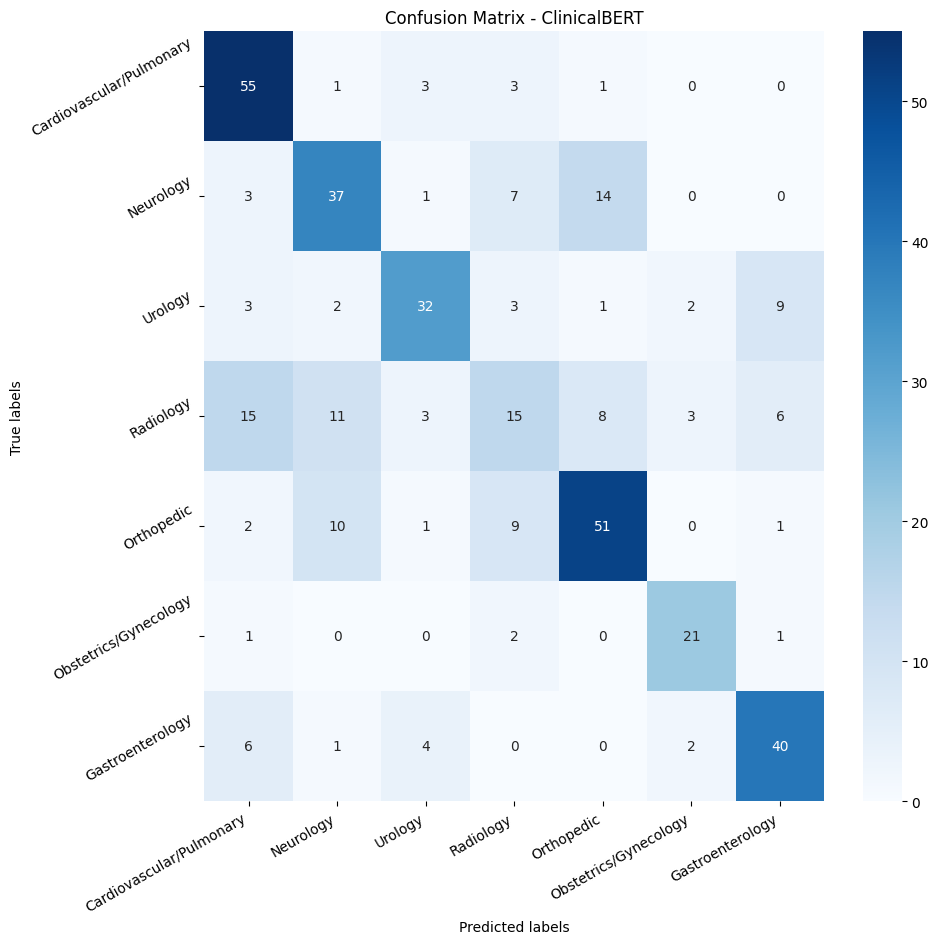

In [ ]:
y_test, y_test_pred = get_predictions(clinical_base_frozen, uniques_ms, dataset_dict_ms)
conf_matrix = confusion_matrix(y_test, y_test_pred , labels =uniques_ms)
plot_confusion_matrix(confusion_matrix=conf_matrix, category_list=uniques_ms, plot_title="ClinicalBERT")

In [ ]:
print(classification_report(y_test,y_test_pred,labels=uniques_ms))

                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.65      0.87      0.74        63
               Neurology       0.60      0.60      0.60        62
                 Urology       0.73      0.62      0.67        52
               Radiology       0.38      0.25      0.30        61
              Orthopedic       0.68      0.69      0.68        74
   Obstetrics/Gynecology       0.75      0.84      0.79        25
        Gastroenterology       0.70      0.75      0.73        53

                accuracy                           0.64       390
               macro avg       0.64      0.66      0.64       390
            weighted avg       0.63      0.64      0.63       390



**Base BERT + FNN Classifier Medical Document Type Fine Tuning**

In [ ]:
finetune(model=uncased_base_frozen_dt, 
             pool=True,
             learning_rate=0.0001,
             num_epochs=NUM_EPOCHS, 
             train_dataloader=train_dataloader_dt, 
             eval_dataloader=eval_dataloader_dt)
save_fine_tune(model=uncased_base_frozen, model_name="uncased_dt_frozen", num_epochs=NUM_EPOCHS)

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch [1/30], Validation Accuracy: 0.4688
Epoch [2/30], Validation Accuracy: 0.4688
Epoch [3/30], Validation Accuracy: 0.5156
Epoch [4/30], Validation Accuracy: 0.4688
Epoch [5/30], Validation Accuracy: 0.5312
Epoch [6/30], Validation Accuracy: 0.5156
Epoch [7/30], Validation Accuracy: 0.5156
Epoch [8/30], Validation Accuracy: 0.4844
Epoch [9/30], Validation Accuracy: 0.5469
Epoch [10/30], Validation Accuracy: 0.5312
Epoch [11/30], Validation Accuracy: 0.5312
Epoch [12/30], Validation Accuracy: 0.5156
Epoch [13/30], Validation Accuracy: 0.5625
Epoch [14/30], Validation Accuracy: 0.5625
Epoch [15/30], Validation Accuracy: 0.5469
Epoch [16/30], Validation Accuracy: 0.5312
Epoch [17/30], Validation Accuracy: 0.5312
Epoch [18/30], Validation Accuracy: 0.6406
Epoch [19/30], Validation Accuracy: 0.5781
Epoch [20/30], Validation Accuracy: 0.6094
Epoch [21/30], Validation Accuracy: 0.5625
Epoch [22/30], Validation Accuracy: 0.5781
Epoch [23/30], Validation Accuracy: 0.5938
Epoch [24/30], Valid

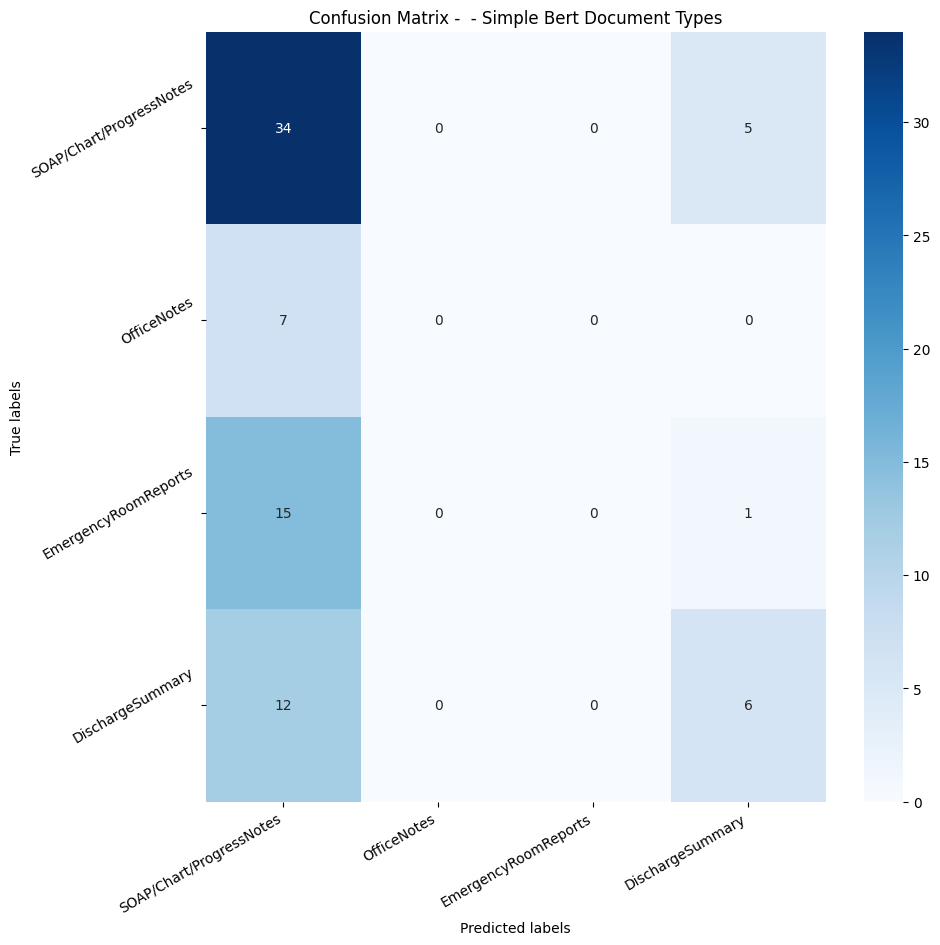

In [ ]:
y_test, y_test_pred = get_predictions(uncased_base_frozen_dt, uniques_dt, dataset_dict_dt)
conf_matrix = confusion_matrix(y_test, y_test_pred , labels =uniques_dt)
plot_confusion_matrix(confusion_matrix=conf_matrix, category_list=uniques_dt, plot_title=" - Simple Bert Document Types")

In [ ]:
print(classification_report(y_test,y_test_pred,labels=uniques_dt))

                          precision    recall  f1-score   support

SOAP/Chart/ProgressNotes       0.50      0.87      0.64        39
             OfficeNotes       0.00      0.00      0.00         7
    EmergencyRoomReports       0.00      0.00      0.00        16
        DischargeSummary       0.50      0.33      0.40        18

                accuracy                           0.50        80
               macro avg       0.25      0.30      0.26        80
            weighted avg       0.36      0.50      0.40        80



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**BioBERT + FNN Classifier Medical Document Type Finetuning**

In [ ]:
finetune(model=biobert_base_frozen_dt, 
             pool=True,
             learning_rate=0.0001,
             num_epochs=NUM_EPOCHS, 
             train_dataloader=train_dataloader_dt, 
             eval_dataloader=eval_dataloader_dt)
save_fine_tune(model=uncased_base_frozen, model_name="biobert_dt_frozen", num_epochs=NUM_EPOCHS)

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch [1/30], Validation Accuracy: 0.4688
Epoch [2/30], Validation Accuracy: 0.4688
Epoch [3/30], Validation Accuracy: 0.4688
Epoch [4/30], Validation Accuracy: 0.5156
Epoch [5/30], Validation Accuracy: 0.5156
Epoch [6/30], Validation Accuracy: 0.5781
Epoch [7/30], Validation Accuracy: 0.6094
Epoch [8/30], Validation Accuracy: 0.6094
Epoch [9/30], Validation Accuracy: 0.6250
Epoch [10/30], Validation Accuracy: 0.6875
Epoch [11/30], Validation Accuracy: 0.7031
Epoch [12/30], Validation Accuracy: 0.7031
Epoch [13/30], Validation Accuracy: 0.7188
Epoch [14/30], Validation Accuracy: 0.7344
Epoch [15/30], Validation Accuracy: 0.7344
Epoch [16/30], Validation Accuracy: 0.7969
Epoch [17/30], Validation Accuracy: 0.7969
Epoch [18/30], Validation Accuracy: 0.8281
Epoch [19/30], Validation Accuracy: 0.8125
Epoch [20/30], Validation Accuracy: 0.7812
Epoch [21/30], Validation Accuracy: 0.8125
Epoch [22/30], Validation Accuracy: 0.8281
Epoch [23/30], Validation Accuracy: 0.7656
Epoch [24/30], Valid

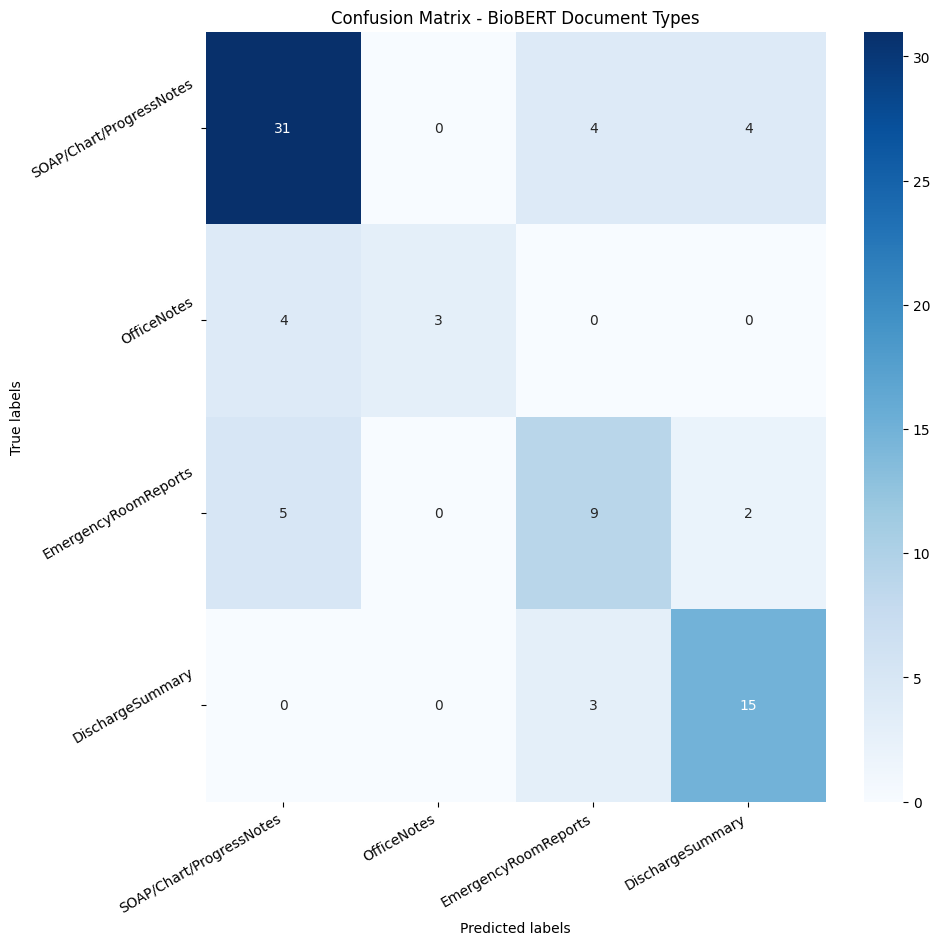

In [ ]:
y_test, y_test_pred = get_predictions(biobert_base_frozen_dt, uniques_dt, dataset_dict_dt)
conf_matrix = confusion_matrix(y_test, y_test_pred , labels =uniques_dt)
plot_confusion_matrix(confusion_matrix=conf_matrix, category_list=uniques_dt, plot_title="BioBERT Document Types")

In [ ]:
print(classification_report(y_test,y_test_pred,labels=uniques_dt))

                          precision    recall  f1-score   support

SOAP/Chart/ProgressNotes       0.78      0.79      0.78        39
             OfficeNotes       1.00      0.43      0.60         7
    EmergencyRoomReports       0.56      0.56      0.56        16
        DischargeSummary       0.71      0.83      0.77        18

                accuracy                           0.73        80
               macro avg       0.76      0.65      0.68        80
            weighted avg       0.74      0.72      0.72        80

